In [183]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from datetime import datetime
pd.options.display.float_format = '{:.2f}'.format
plt.style.use('fivethirtyeight')
from pylab import rcParams
rcParams['figure.figsize'] = 10, 6

from itertools import combinations
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA as ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt

In [184]:
data = pd.read_excel('ari.xlsx')
df.head()

,berat
tanggal,
2017-01-01,4266
2017-01-02,3986
2017-01-03,4434
2017-01-04,4525
2017-01-05,3467


In [185]:
data.shape

(729, 2)

In [186]:
data.columns

Index(['tanggal', 'berat'], dtype='object')

In [187]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729 entries, 0 to 728
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   tanggal  729 non-null    datetime64[ns]
 1   berat    729 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 11.5 KB


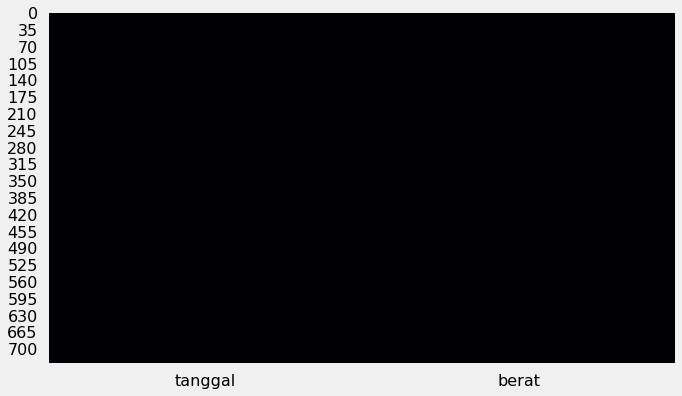

In [188]:
sns.heatmap(data.isnull(),cmap = 'magma',cbar = False);

In [189]:
data.describe()

,berat
count,729.00
mean,7490.75
std,2326.39
min,1588.00
25%,5952.00
50%,7457.00
75%,8836.00
max,16929.00


In [190]:
data['Date'] = pd.to_datetime(data['tanggal'])
data = data.drop(columns = 'tanggal')
data = data.set_index('Date')
data = data.rename(columns = {'berat':'berat'})
data.head()

,berat
Date,
2018-01-02,5449
2018-01-03,3636
2018-01-04,4829
2018-01-05,9713
2018-01-06,8706


In [191]:
def test_stationarity(timeseries):
    #Determing rolling statistics
    MA = timeseries.rolling(window=12).mean()
    MSTD = timeseries.rolling(window=12).std()

    #Plot rolling statistics:
    plt.figure(figsize=(15,5))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(MA, color='red', label='Rolling Mean')
    std = plt.plot(MSTD, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [192]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

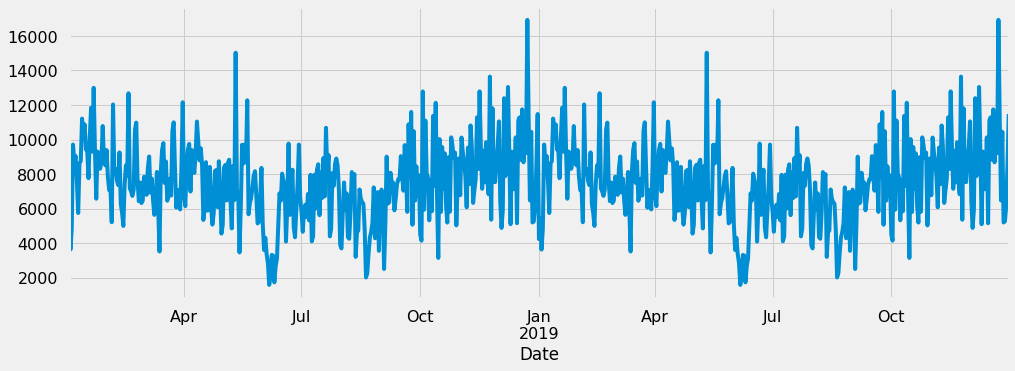

In [193]:
plt.figure(figsize = (15,5))
data['berat'].plot();

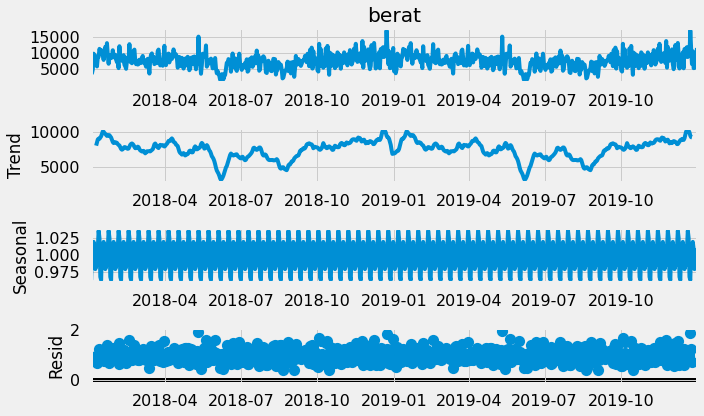

<Figure size 1152x648 with 0 Axes>

In [195]:
result = seasonal_decompose(data['berat'],period = 12, model = 'multiplicative').plot()
fig = plt.figure()  
# fig = result.plot()  
fig.set_size_inches(16, 9)

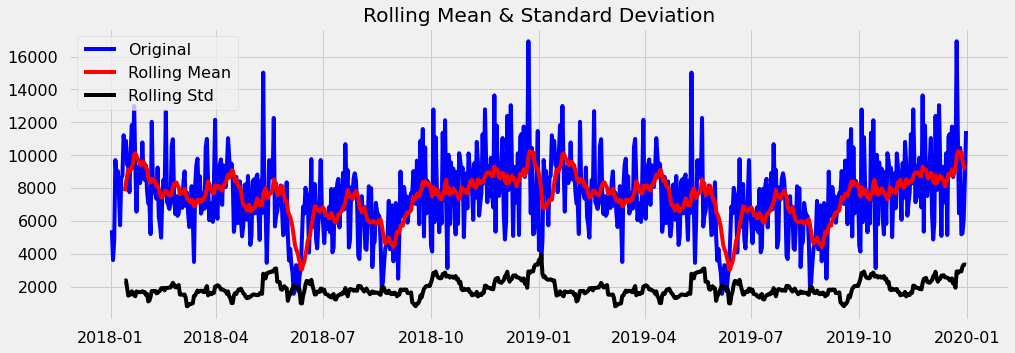

Results of Dickey-Fuller Test:
Test Statistic                 -4.02
p-value                         0.00
#Lags Used                     19.00
Number of Observations Used   709.00
Critical Value (1%)            -3.44
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [196]:
test_stationarity(data['berat'])

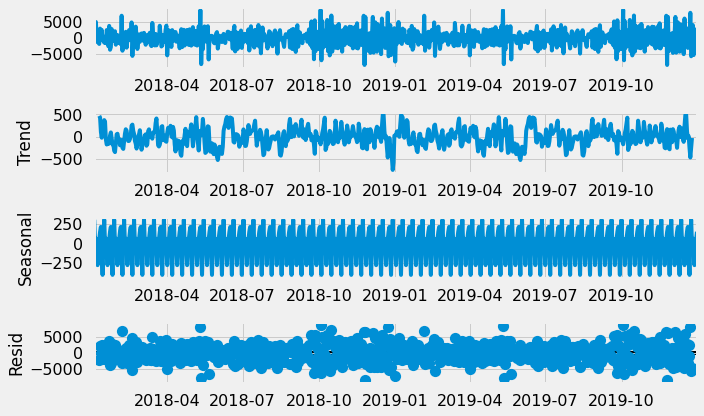

In [197]:
data_diff = data.diff()
data_diff = data_diff.dropna()

dec = sm.tsa.seasonal_decompose(data_diff,period = 12).plot()
plt.show()

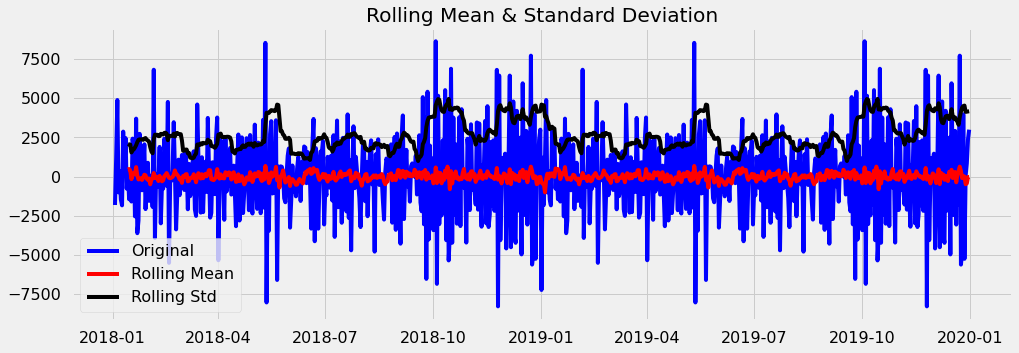

Results of Dickey-Fuller Test:
Test Statistic                 -9.23
p-value                         0.00
#Lags Used                     20.00
Number of Observations Used   707.00
Critical Value (1%)            -3.44
Critical Value (5%)            -2.87
Critical Value (10%)           -2.57
dtype: float64


In [198]:
test_stationarity(data_diff)

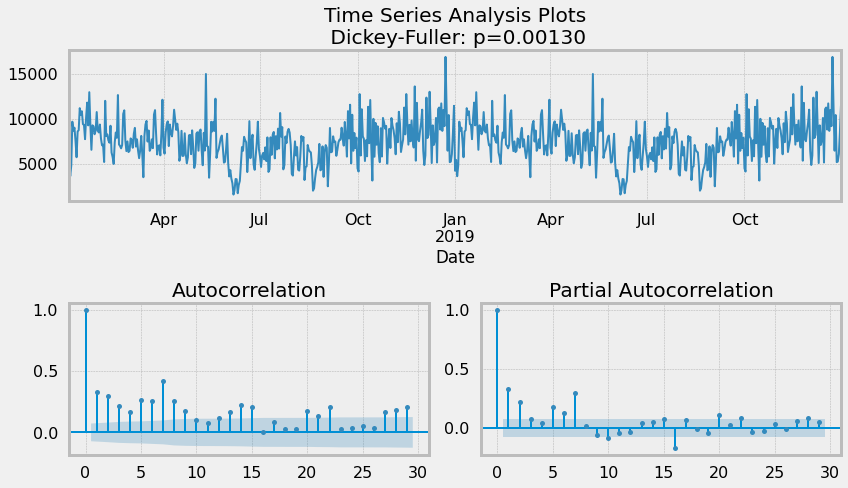

In [199]:
tsplot(data['berat'])

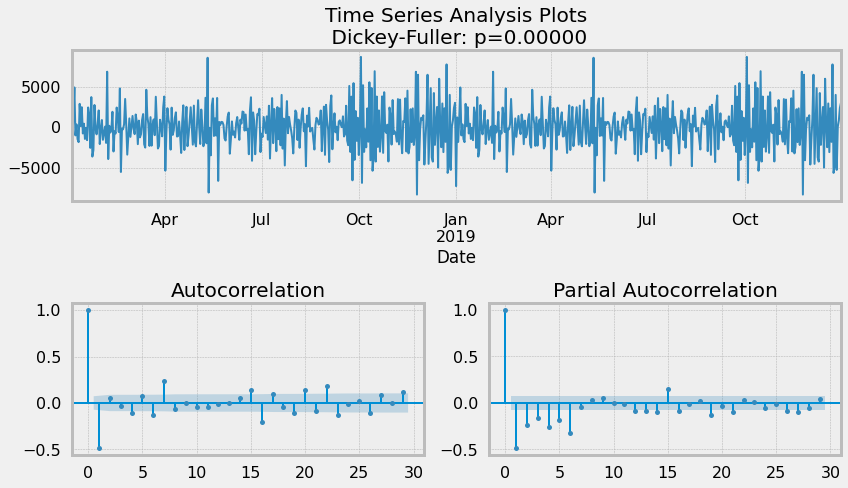

In [200]:
tsplot(data_diff['berat'])

In [201]:
model = ARIMA(data['berat'],order = (2,1,2))
model_fit = model.fit()
print(model_fit.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           12

At X0         0 variables are exactly at the bounds

At iterate    0    f=  9.07162D+00    |proj g|=  4.70433D-03

At iterate    5    f=  9.07114D+00    |proj g|=  7.28360D-03

At iterate   10    f=  9.06956D+00    |proj g|=  2.23999D-04

At iterate   15    f=  9.06956D+00    |proj g|=  3.13527D-04


 This problem is unconstrained.



At iterate   20    f=  9.06950D+00    |proj g|=  5.71632D-04

At iterate   25    f=  9.06949D+00    |proj g|=  4.61853D-06

At iterate   30    f=  9.06949D+00    |proj g|=  5.32907D-07

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     32     41      1     0     0   1.243D-06   9.069D+00
  F =   9.0694929349625450     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                             ARIMA Model Results                              
Dep. Variable:                D.berat   No. Observations:                  728
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -6602.591


In [202]:
size = int(len(data) - 30)
train, test = data['berat'][0:size], data['berat'][size:len(data)]

print('\t ARIMA MODEL : In- Sample Forecasting \n')

history = [x for x in train]
predictions = []

for t in range(len(test)):
    
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit(disp = 0)
    
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    
    obs = test[t]
    history.append(obs)
    
    print('predicted = %f, expected = %f' % (yhat, obs))

	 ARIMA MODEL : In- Sample Forecasting 

predicted = 8994.977745, expected = 6466.000000
predicted = 8319.245865, expected = 4887.000000
predicted = 7672.671728, expected = 5952.000000
predicted = 7439.661566, expected = 12396.000000
predicted = 8497.020802, expected = 7888.000000
predicted = 8151.913639, expected = 8251.000000
predicted = 8147.028484, expected = 13046.000000
predicted = 9073.675189, expected = 9332.000000
predicted = 8872.945904, expected = 5104.000000
predicted = 8048.518332, expected = 9302.000000
predicted = 8409.747334, expected = 7127.000000
predicted = 8082.813933, expected = 7644.000000
predicted = 8014.606423, expected = 10126.000000
predicted = 8417.380199, expected = 5161.000000
predicted = 7679.276522, expected = 11113.000000
predicted = 8420.479329, expected = 11290.000000
predicted = 8830.179413, expected = 8832.000000
predicted = 8662.552445, expected = 11748.000000
predicted = 9347.319221, expected = 8685.000000
predicted = 9067.387849, expected = 11015

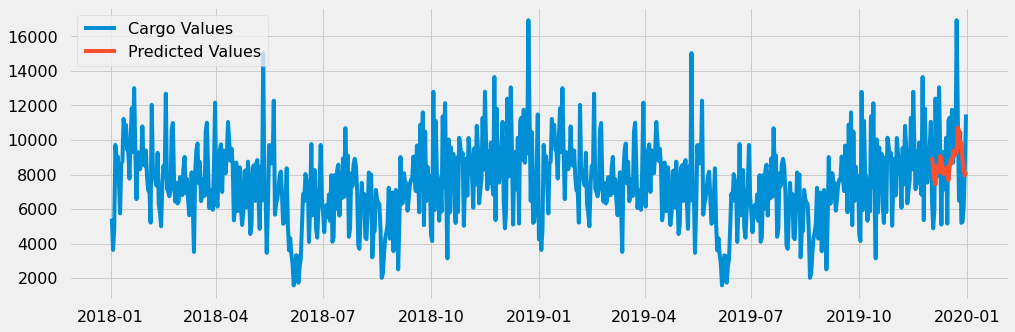

In [203]:
predictions_series = pd.Series(predictions, index = test.index)
fig,ax = plt.subplots(nrows = 1,ncols = 1,figsize = (15,5))

plt.subplot(1,1,1)
plt.plot(data['berat'],label = 'Cargo Values')
plt.plot(predictions_series,label = 'Predicted Values');
plt.legend(loc="upper left")
plt.show()

In [206]:
# error = np.sqrt(mean_squared_error(test,predictions))
# print('Test RMSE: %.4f' % error)

# report performance
mse = mean_squared_error(test,predictions)
print('MSE: '+str(mse))
mae = mean_absolute_error(test,predictions)
print('MAE: '+str(mae)) 
rmse = np.sqrt(mean_squared_error(test,predictions))
print('RMSE: '+str(rmse))

MSE: 8758795.476246322
MAE: 2339.473598546281
RMSE: 2959.526224963435


In [208]:
from pandas.tseries.offsets import DateOffset
future_dates = [data.index[-1] + DateOffset(weeks = x) for x in range(0,49)]

# New dataframe for storing the future values
df1 = pd.DataFrame(index = future_dates[1:],columns = data.columns)

forecast = pd.concat([data,df1])
forecast['ARIMA_Forecast_Function'] = np.NaN
forecast['ARIMA_Predict_Function'] = np.NaN
forecast.head()

,berat,ARIMA_Forecast_Function,ARIMA_Predict_Function
2018-01-02,5449,NaN,NaN
2018-01-03,3636,NaN,NaN
2018-01-04,4829,NaN,NaN
2018-01-05,9713,NaN,NaN
2018-01-06,8706,NaN,NaN


In [210]:
ARIMA_history_f = [x for x in train]
f1 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_f, order = (1,0,2))
    model_fit = model.fit(disp=0)
    
    output = model_fit.forecast()[0][0]
    
    ARIMA_history_f.append(output)
    f1.append(output)
    
for i in range(len(f1)):
    forecast.iloc[729 + i,1] = f1[i]
forecast.tail()

,berat,ARIMA_Forecast_Function,ARIMA_Predict_Function
2020-11-03,NaN,7599.67,NaN
2020-11-10,NaN,7592.49,NaN
2020-11-17,NaN,7584.80,NaN
2020-11-24,NaN,7580.65,NaN
2020-12-01,NaN,7573.70,NaN


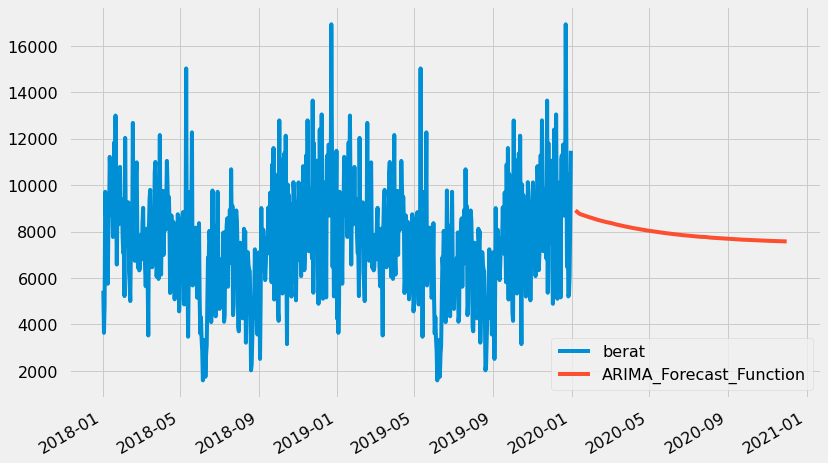

In [211]:
forecast[['berat','ARIMA_Forecast_Function']].plot(figsize = (12,8));

In [212]:
ARIMA_history_p = [x for x in train]
f2 = []

for t in range(len(df1)):
    
    model = ARIMA(ARIMA_history_p, order = (2,1,2))
    model_fit = model.fit(disp=0)
    
    output = model_fit.predict(start = len(ARIMA_history_p),end = len(ARIMA_history_p),typ = 'levels')[0]
    
    ARIMA_history_p.append(output)
    f2.append(output)
    
for i in range(len(f2)):
    forecast.iloc[729 + i,2] = f2[i]
forecast.tail()

,berat,ARIMA_Forecast_Function,ARIMA_Predict_Function
2020-11-03,NaN,7599.67,7708.98
2020-11-10,NaN,7592.49,7701.31
2020-11-17,NaN,7584.80,7696.43
2020-11-24,NaN,7580.65,7687.06
2020-12-01,NaN,7573.70,7680.20


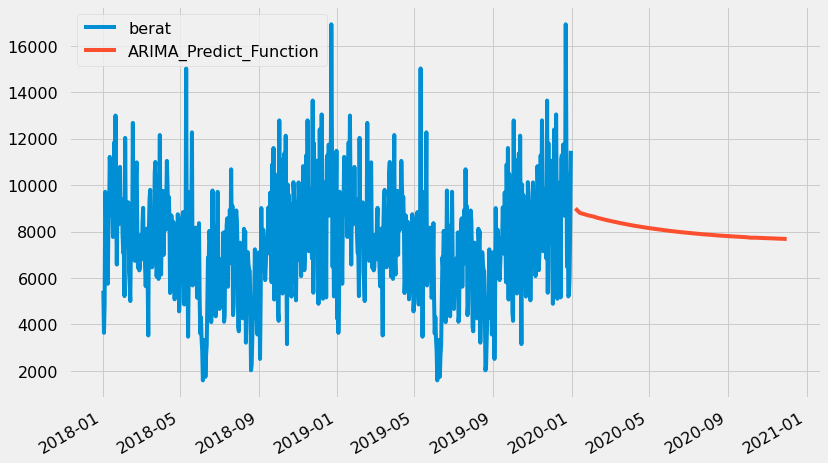

In [213]:
forecast[['berat','ARIMA_Predict_Function']].plot(figsize = (12,8));

In [145]:
sum(f1) == sum(f2)

True